In [1]:
# 导入相关模块
import torch
import torch.nn as nn

### 定义生成器
class Generator(nn.Module):
    def __init__(self, z_dim=64, image_channel=1, hidden_dim=128):
        super(Generator, self).__init__()
        # 随机噪声长度
        self.z_dim = z_dim
        # 生成器结构
        # 由四个连续的转置卷积块构成
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim * 4),
            self.gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.gen_block(hidden_dim * 2, hidden_dim),
            nn.Sequential(
                nn.ConvTranspose2d(hidden_dim, image_channel, kernel_size=4, stride=2),
                nn.Tanh(),
            )
        )
    
    # 定义生成器转置卷积块
    def gen_block(self, input_c, output_c, kernel_size=3, stride=2):
        return nn.Sequential(
            nn.ConvTranspose2d(input_c, output_c, kernel_size, stride),
            nn.BatchNorm2d(output_c),
            nn.ReLU(inplace=True),
            )

    # 生成器前向计算流程
    def forward(self, x):
        # 噪声向量重塑
        x = x.view(len(x), self.z_dim, 1, 1)
        return self.gen(x)

In [2]:
### 定义判别器
class Discriminator(nn.Module):
    def __init__(self, image_channel=1, hidden_dim=32):
        super(Discriminator, self).__init__()
        # 判别器结构
        # 由连续三个卷积块构成
        self.disc = nn.Sequential(
            self.disc_block(image_channel, hidden_dim),
            self.disc_block(hidden_dim, hidden_dim * 2),
            nn.Conv2d(hidden_dim * 2, 1, kernel_size=4),
        )
    
    # 定义判别器卷积块
    def disc_block(self, input_c, output_c, kernel_size=4, stride=2):
        return nn.Sequential(
            nn.Conv2d(input_c, output_c, kernel_size, stride),
            nn.BatchNorm2d(output_c),
            nn.LeakyReLU(0.1, inplace=True),
        )
    
    # 判别器前向计算流程
    def forward(self, x):
        disc_res = self.disc(x)
        # 结果重塑
        return disc_res.view(len(disc_res), -1)

In [3]:
from torchvision import datasets
import torchvision.transforms as T
from torch.utils.data.dataloader import DataLoader

# 基于transform进行图像变换
# 包括将图像转化为torch tensor和规范化到(-1,1)
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,)),
])

# Fashion MNIST数据下载
FashionMnist_dataset = datasets.FashionMNIST('../dataset', download=True, train=True, transform=transform)
# Fashion MNIST数据导入
dataloader = DataLoader(FashionMnist_dataset, batch_size=256, shuffle=True)

In [4]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)

# 定义显示图像阵列函数
def plot_image_grid(image, num_images=25, size=(1, 28, 28)):
    image = (image + 1) / 2
    image = image.detach().cpu()
    image_grid = make_grid(image[:num_images], nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [5]:
# 训练轮数
num_epochs = 100
# 噪声向量维度
z_dim = 64
# 计算平均损失迭代次数
display_step = 500
# 当前迭代步数
cur_step = 0
# 学习率
lr = 0.0002
# 指定损失函数
criterion = nn.BCEWithLogitsLoss()
# 初始化生成器和判别器平均损失为0
mean_g_loss = 0
mean_d_loss = 0

# 创建生成器模型实例
generator = Generator(z_dim).to('cuda')
# 指定生成器优化器
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
# 创建判别器模型实例
discriminator = Discriminator().to('cuda') 
# 指定判别器优化器
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

Step 500: Generator loss: 1.7446651828289041, discriminator loss: 0.35209368309378647


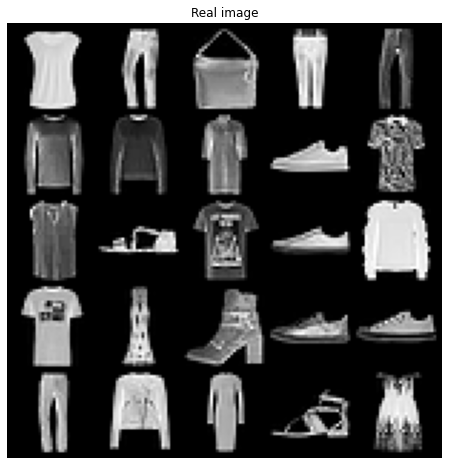

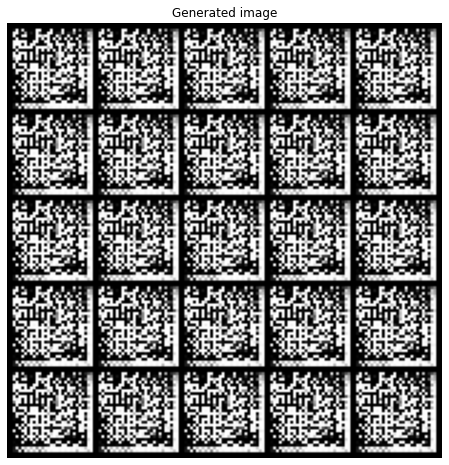

Step 1000: Generator loss: 2.8886359419822676, discriminator loss: 0.10702390380948777


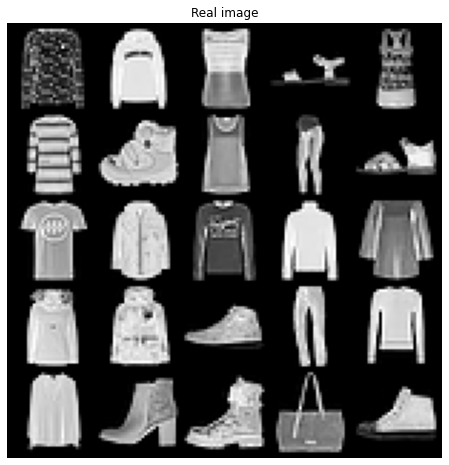

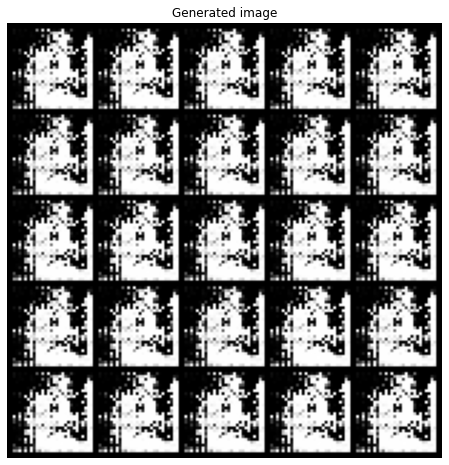

Step 1500: Generator loss: 1.4062252941131583, discriminator loss: 0.4965829499661924


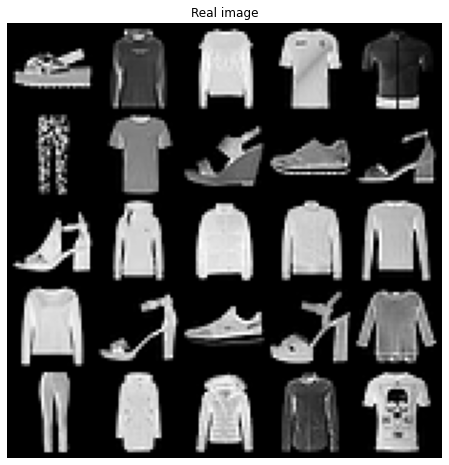

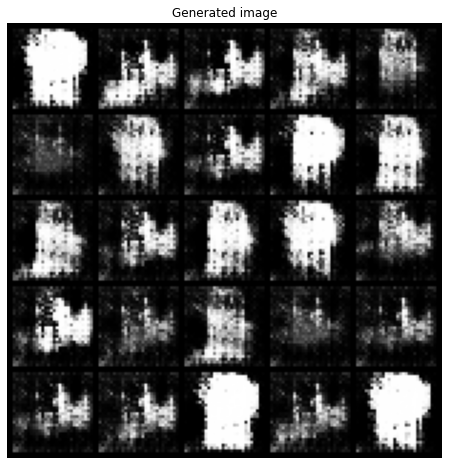

Step 2000: Generator loss: 0.7710816470384595, discriminator loss: 0.6901805005073548


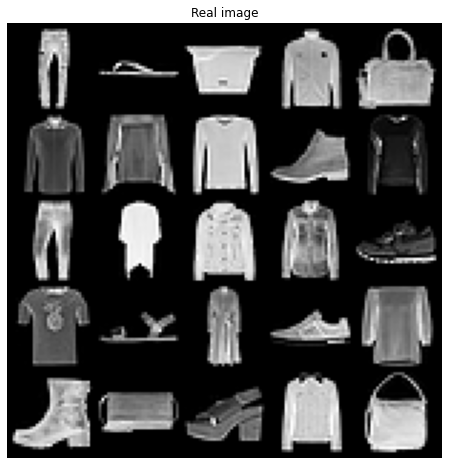

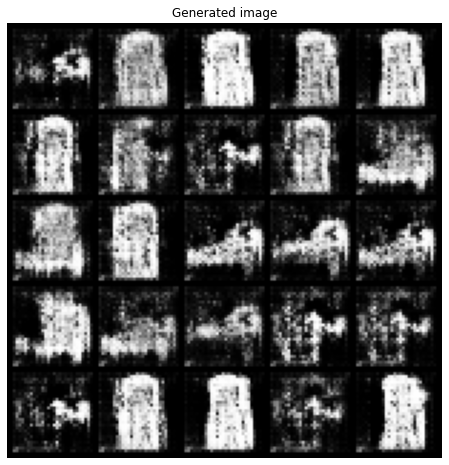

Step 2500: Generator loss: 0.6959472506046293, discriminator loss: 0.7084611797332774


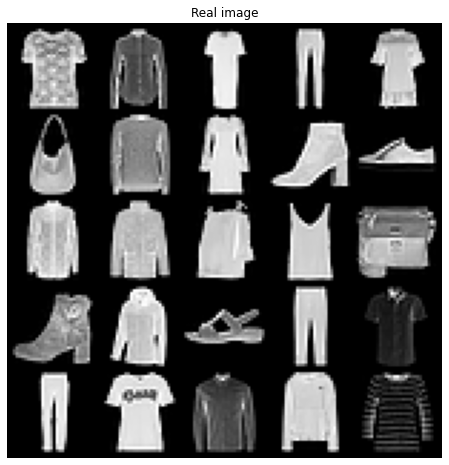

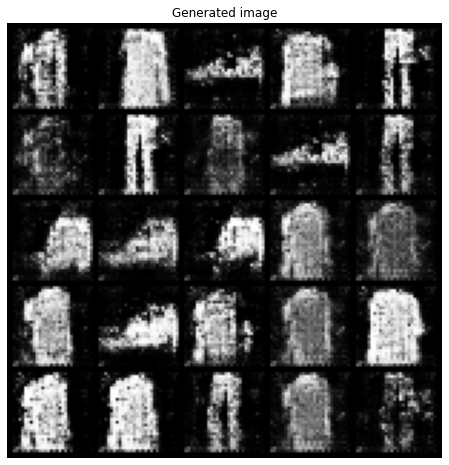

In [ ]:
# 执行DCGAN训练
for epoch in range(num_epochs):
    # 导入训练数据
    for _, (real, _) in enumerate(dataloader):
        # 输入为真实图像，转为cuda形式
        real = real.to('cuda')
        # 当前训练批次大小
        batch_size = real.size(0)

        ### 更新判别器
        optimizerD.zero_grad()
        # 基于当前批次大小生成噪声向量
        noise = torch.randn(batch_size, z_dim, device='cuda')
        # 基于生成器模型对噪声向量生成虚假图像
        fake = generator(noise)
        # 判别器需要对生成的虚假图像进行预测
        output_fake = discriminator(fake.detach())
        # 判别器损计算虚假图像损失
        d_loss_fake = criterion(output_fake, torch.zeros_like(output_fake))
        # 同时判别器对真实图像进行预测
        output_real = discriminator(real)
        # 判别器计算真实图像损失
        d_loss_real = criterion(output_real, torch.ones_like(output_real))
        # 判别器最终损失等于虚假损失和真实损失的平均
        d_loss = (d_loss_fake + d_loss_real) / 2
        # 记录判别器平均损失
        mean_d_loss += d_loss.item() / display_step
        # 更新判别器梯度
        d_loss.backward(retain_graph=True)
        # 更新优化器
        optimizerD.step()

        ### 更新生成器
        optimizerG.zero_grad()
        # 基于当前批次大小生成第二个噪声向量
        noise_2 = torch.randn(batch_size, z_dim, device='cuda')
        # 基于生成器模型生成第二个虚假图像
        fake_2 = generator(noise_2)
        # 判别器需要对生成的虚假图像进行预测
        output_fake = discriminator(fake_2)
        # 计算生成器损失
        g_loss = criterion(output_fake, torch.ones_like(output_fake))
        # 生成器反向传播
        g_loss.backward()
        optimizerG.step()
        # 记录生成器平均损失
        mean_g_loss += g_loss.item() / display_step
        ### 打印训练损失
        if cur_step % 500 == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_g_loss}, discriminator loss: {mean_d_loss}")
            plt.title("Real image")
            plot_image_grid(real)
            plt.title("Generated image")
            plot_image_grid(fake)
            mean_g_loss = 0
            mean_d_loss = 0
        cur_step += 1